<a href="https://colab.research.google.com/github/vincentmartin/tp-initiation-llm-student-version/blob/main/TP_initiation_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP d'initiation aux LLM

Dans ce TP, vous allez apprendre les bases de l'IA générative en manipulant et en contrôlant un LLM installé en local.

En sortie de ce module, vous serez capable de :
- Installer et importer les dépendances nécessaires
- Interroger un LLM pour répondre à tout type de question, comme avec chatGPT
- Analyser le fonctionnement d'un LLM
- Utiliser un LLM pour résumer une conversation
- Explorer les techniques de zero-shot, one-shot et few-shot inference

### Instruction à suivre pour exécution sur Google Colab

Aller dans `Execution -> Modifier le type d'exécution` puis sélectionner `T4-GPU` pour exploiter les fonctionnalités GPU.

![Colab GPU](resources/colab_gpu.png "T4-GPU")

## Installation des dépendances

Installons les dépendances nécessaires :
- **transformers** : la bibliothèque permettant de mettre en oeuvre les LLM exploitant le modèle transformers
- **torch** : célèbre bibliothèque de deep learning, sous jacente à transformers

In [1]:
%pip install -U datasets

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch \
    torchdata

%pip install \
    transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Chargeons les dépendances.

**Remarque : Si l'exécution ressort en erreur ; tenter de recharger les dépendances.**

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import torch

## Chargement du LLM

Pour interagir avec un LLM, nous allons d'abord devoir le télécharger. Pour cet exemple, nous choissons un modèle simple et "léger" : flan-t5.

Nous chargeons également le **Tokenizer** afin de convertir le texte en tokens et vice-versa.

In [4]:
model_name='google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

**Exercice** : en vous aidant de la documentation https://huggingface.co/docs/transformers/llm_tutorial :
- Générer et afficher les tokens (ids) de la phrase (encodage)
- Décoder la liste de tokens (ids) et afficher la phrase (décodage)

In [5]:
sentence = "Que peux-tu me dire sur les LLMs ?"

device = torch.device("cuda")

# Encoder la phrase en tokens : suite d'ID ; 1 ID = 1 token

inputs = tokenizer(sentence, return_tensors="pt").to(device)

print("\nTokens encodés :", inputs["input_ids"][0])

# METTRE ICI LE CODE POUR DECOER UNE SEQUENCE D'ID EN PHRASE ET L'AFFICHER

res = tokenizer.batch_decode(inputs["input_ids"][0], skip_special_tokens=True)
print("\nDécodage des tokens :", res)

st = ""
for token in res:
  st += token

print("\n", st)


Tokens encodés : tensor([ 7227,     3, 16162,    18,    17,    76,   140,  5794,   244,   110,
          301, 11160,     7,     3,    58,     1], device='cuda:0')

Décodage des tokens : ['Que', '', 'peux', '-', 't', 'u', 'me', 'dire', 'sur', 'les', 'L', 'LM', 's', '', '?', '']

 Quepeux-tumediresurlesLLMs?


## Interrogation du LLM

A présent, utilisons notre LLM pour générer du texte.

Notez la syntaxe `User: question? Assistant: "`. Nous utilisons cette syntaxe car le LLM est un modèle qui génère la suite de la phrase et cette syntaxe lui permet de comprendre ce qu'on attend de lui. Ceci à la différence des modèles d'instruction qui génèrent une réponse pour une instruction donnée.

In [6]:
sentence = "User: quelle est la capitale de la france ?Assistant: "

inputs = tokenizer(sentence, return_tensors='pt') # return les tenseurs au format pytorch
inputs = {k: v.to("cuda") for k, v in inputs.items()}
model = model.to("cuda")

output_ids = model.generate(
    inputs["input_ids"],
    max_new_tokens=50
)

output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(output)

Paris


C'est assez basique pour l'instant mais ne vous inquiétez pas, ce n'est que le premier TP ;).

## Résumé de dialogues

Dans cette partie, nous allons utiliser le LLM pour résumer des dialogues.

Tout d'abord, téléchargeons le dataset [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) depuis Huggingface

In [7]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Affichons 2 exemples de dialogues, les exemples numéro 40 et 200.

In [8]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('DIALOGUE D ENTREE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('RESUME HUMAIN:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
DIALOGUE D ENTREE:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
RESUME HUMAIN:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Example  

Tentons une première approche pour résumer les dialogues 40 et 200.

In [9]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    inputs = tokenizer(dialogue, return_tensors='pt') # retourner les tenseurs
    inputs = {k: v.to("cuda") for k, v in inputs.items()}
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50, # max 50 tokens générés
        )[0],
        skip_special_tokens=True # on ne génère pas les tokens spéciaux <, >, ...
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'DIALOGUE D ENTREE::\n{dialogue}')
    print(dash_line)
    print(f'RESUME HUMAIN:\n{summary}')
    print(dash_line)
    print(f'RESUME PAR LLM SANS PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
DIALOGUE D ENTREE::
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
RESUME HUMAIN:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
RESUME PAR LLM SANS PROMPT ENGINEERING:
Person1: It's ten to nine.

-----------------------------------------

**Exercice** : selon vous est-ce que le résumé est bon ? Pourquoi ?

Le résumé n'est pas bon car das les deux cas, le LLM retourne seulement une information précise qu'il a compris du texte, mais qui ne résume pas du tout le texte.

## Résumé avec un prompt Instruction

Dans l'exemple ci-dessous, ajoutons une instruction indiquant au LLM ce qu'il doit faire.

### 1. Zero shot inference

Pour amener le modèle à accomplir une tâche, comme résumer un dialogue, vous pouvez transformer ce dialogue en une consigne spécifique. Cela est connu sous le nom d'inférence zéro-shot.

En encadrant le dialogue dans une consigne descriptive, vous pourrez observer les modifications apportées au texte généré.

In [11]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation between two persons to extract the key points of the conversation.

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = {k: v.to("cuda") for k, v in inputs.items()}
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'DIALOGUE D ENTREE:\n{prompt}')
    print(dash_line)
    print(f'RESME HUMAIN:\n{summary}')
    print(dash_line)
    print(f'>>>RESME AVEC ZERO SHOT INFERENCE:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
DIALOGUE D ENTREE:

Summarize the following conversation between two persons to extract the key points of the conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
RESME HUMAIN:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
------------------------------------------------------------------------------------------

C'est déjà mieux ! Mais on peut encore faire mieux. Essayons de rajouter un exemple de résumé.

### 2. One Shot Inference

L'inférence one-shot et few-shot consiste à fournir au modèle de langage un ou plusieurs exemples complets de paires consigne-réponse correspondant à votre tâche avant de lui soumettre la consigne réelle que vous souhaitez qu'il accomplisse. Cela s'appelle "l'apprentissage en contexte" (_in context learning_), et cela permet au modèle de comprendre votre tâche spécifique. Pour en savoir plus, vous pouvez consulter [cet article](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

Définissons une fonction qui permet de générer un prompt avec 1 exemple de dialogue et son résumé.

In [12]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']

        # The stop sequence '{summary}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Dialogue:

{dialogue}

Summary:
{summary}


"""

    dialogue = dataset['test'][example_index_to_summarize]['dialogue']

    prompt += f"""
Dialogue:

{dialogue}

Summary:
"""

    return prompt

Construsons le prompt et affichons le.

In [13]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)
# one_shot_prompt is a string
print(one_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more 

Lançons l'inférence sur un dialogue, qui doit bien entendu être différent de celui utilisé pour réaliser l'exemple.

In [14]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
inputs = {k: v.to("cuda") for k, v in inputs.items()}
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'RESME HUMAIN:\n{summary}\n')
print(dash_line)
print(f'>>>RESME LLM AVEC ONE SHOT INFERENCE:\n{output}')

---------------------------------------------------------------------------------------------------
RESME HUMAIN:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
>>>RESME LLM AVEC ONE SHOT INFERENCE:
#Person1#: You could add a painting program to your software. #Person2#: That would be a bonus. #Person1#: You might also want to upgrade your hardware because it is pretty outdated now


Voilà qui est encore mieux !!

### 3. Few shot inference

Essayons à présent de fournir 3 exemples de paires (dialogue, résumé). C'est ce que l'on appelle le **few shot inference**.

In [15]:
example_indices_full = [91, 93, 97] # exemples à fournir
example_index_to_summarize = 210 # dialogue à résumer

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: What's wrong with you, Mr. Polly?
#Person2#: What's wrong? I want a break from this horrible job.
#Person1#: Then, buy a bottle of soft drink.
#Person2#: Would you like to buy a bottle for me in the shop?
#Person1#: It's a problem, because my boss is in that shop now.
#Person2#: Ok, I will go there myself.
#Person1#: Sorry, Mr. Polly.
#Person2#: It doesn't matter. Oh, God, I have only four dollars in my wallet. Is that possible for me to buy one?
#Person1#: Have a try.

Summary:
Mr. Polly wants to get a break from work and he asks #Person1# to buy a drink for him, but #Person1# refuses.



Dialogue:

#Person1#: Hello, this is Francis.
#Person2#: Hi, this is Monica. I was wondering when we can work on this financial report.
#Person1#: Today, I am busy all day long.
#Person2#: Shall I see you on Friday morning?
#Person1#: That's not good for me at all. It'll have to be another time.
#Person2#: We must find some time to read report.
#Person1#: I know. I am available

In [16]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
inputs = {k: v.to("cuda") for k, v in inputs.items()}
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'RESUME HUMAIN:\n{summary}\n')
print(dash_line)
print(f'>>>RESUME LLM AVEC FEW SHOT INFERENCE:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
RESUME HUMAIN:
#Person1# is visiting a large plant and #Person2# introduces its basic information.

---------------------------------------------------------------------------------------------------
>>>RESUME LLM AVEC FEW SHOT INFERENCE:
The plant is a large plant with a capacity of 500 employees. It was set up in the early 70s. It's 30 years old.


**Exercice** : modifier les exemples fournis en entrée et indiquer ce que vous contacter en commentaire dans une section markdown.

Le fait de changer les dialogues d'exemple change aussi la réponse que fait le LLM.

## Influence des paramètres du LLM

Nous allons maintenant faire varier plusieurs paramètres du LLM :
- température
- top_k
- top_p
- sampling

Pour cela aidez-vous de la documentation :
- https://huggingface.co/docs/transformers/generation_strategies
- https://huggingface.co/docs/transformers/main_classes/text_generation

**Exercice** : créer une fonction qui prend les 4 paramètres ci-dessous et le paramètres _few_shot_prompt_ défini précédemment et qui retourne le résultat de la génération.

In [17]:
def generate_summary(temperature, top_k, top_p, sampling, prompt):
    inputs = tokenizer(prompt, return_tensors='pt')
    inputs = {k: v.to("cuda") for k, v in inputs.items()}
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
            do_sample=sampling,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
        )[0],
        skip_special_tokens=True
    )
    return output

In [18]:
# Test de generate_summary
dialogue = dataset['test'][201]['dialogue']
human_summary = dataset['test'][201]['summary']

print("Dialogue:\n")
print(dialogue)
print("\nHuman Summary:")
print(human_summary)
print("\nGenerated Summary:")
output = generate_summary(0.7, 50, 0.9, True, few_shot_prompt)
print(output)

Dialogue:

#Person1#: Where to, miss?
#Person2#: Hi! Crenshaw and Hawthorne, at the Holiday Inn that is on that corner.
#Person1#: Sure thing. So, where are you flying in from?
#Person2#: From China.
#Person1#: Really? You don't look very Chinese to me, if you don't mind me saying so.
#Person2#: It's fine. I am actually from Mexico. I was in China on a business trip, visiting some local companies that manufacture bathroom products.
#Person1#: Wow sounds interesting! Excuse me if I am being a bit nosy but, how old are you?
#Person2#: Don't you know it's rude to ask a lady her age?
#Person1#: Don't get me wrong! It's just that you seem so young and already doing business overseas!
#Person2#: Well thank you! In that case, I am 26 years old, and what about yourself?
#Person1#: I am 40 years old and was born and raised here in the good old U. S of A, although I have some Colombian heritage.
#Person2#: Really? That's great! Do you speak some Spanish?
#Person1#: Uh. . . yeah. . of course!
#Pe

In [19]:
# Exemples de valeurs de paramètres à l'inférence à tester (température, top_k, top_p, sampling)
param_sets = [
    (0.7, 50, 0.9, True),
    (1.0, 50, 0.9, True),
    (0.5, 50, 0.9, True),
    (0.7, 20, 0.9, True),
    (0.7, 50, 0.5, True),
    (0.7, 50, 0.9, False),
]

# Dialogues à tester
dialogue_indices = [11, 45, 199]

# Dialogues d'exemples résumés pour le few-shots
few_shot_examples = [84, 85, 86]

for dialogue_idx in dialogue_indices:
    dialogue_text = dataset['test'][dialogue_idx]['dialogue']
    human_summary = dataset['test'][dialogue_idx]['summary']

    print(f"\nDialogue {dialogue_idx}:")
    print(f"Human Summary: {human_summary}")

    for i, params in enumerate(param_sets):
        print(f"\n--- Parameter Set {i+1}: temp={params[0]}, top_k={params[1]}, top_p={params[2]}, sampling={params[3]} ---")

        # Création du prompt
        prompt = make_prompt(few_shot_examples, dialogue_idx)

        # Génération de la réponse
        output = generate_summary(*params, prompt)

        print(f"Generated Summary: {output}")

    print(dash_line, "\n\n")


Dialogue 11:
Human Summary: #Person1# has a dance with Brian at Brian's birthday party. Brian thinks #Person1# looks great and is popular.

--- Parameter Set 1: temp=0.7, top_k=50, top_p=0.9, sampling=True ---
Generated Summary: Brian had a birthday party and he would like to have a dance with Person2 as he is always popular with everyone.

--- Parameter Set 2: temp=1.0, top_k=50, top_p=0.9, sampling=True ---
Generated Summary: #Person1 wished Brian a happy birthday party.

--- Parameter Set 3: temp=0.5, top_k=50, top_p=0.9, sampling=True ---
Generated Summary: #Person1 wants to invite Brian to the party.

--- Parameter Set 4: temp=0.7, top_k=20, top_p=0.9, sampling=True ---
Generated Summary: Brian's birthday is coming up.

--- Parameter Set 5: temp=0.7, top_k=50, top_p=0.5, sampling=True ---


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated Summary: #Person1#: Happy birthday, Brian. #Person2#: Great party, Brian. #Person1#: I'm so happy you remember. #Person2#: Yes, I'm always popular with

--- Parameter Set 6: temp=0.7, top_k=50, top_p=0.9, sampling=False ---
Generated Summary: #Person1#: Happy birthday, Brian. #Person2#: I'm so happy you remember. #Person1#: This is really wonderful party. #Person2#: You look very pretty today. #
--------------------------------------------------------------------------------------------------- 



Dialogue 45:
Human Summary: #Person1# tells #Person2# that Ruojia is married and will have a party tonight. #Person2#'s surprised to know that. They will bring their gifts to bless her.

--- Parameter Set 1: temp=0.7, top_k=50, top_p=0.9, sampling=True ---
Generated Summary: Ruojia has got married. She has sent an email about it yesterday.

--- Parameter Set 2: temp=1.0, top_k=50, top_p=0.9, sampling=True ---
Generated Summary: People at the Ruojia's wedding party invited. Ruojia's 

**Exercice** : expliquer en 1 ou 2 lignes l'influence de chacun des 4 paramètres (dans une section markdown).

La température semble être le paramètre le plus important car le cas avec une température de 1 est le seul cas qui donne un résumé satisfaisant qui n'est pas une information au hasard du dialogue.

Les autres paramètres ne semblent pas influencer beaucoup la réponse en comparaison.

### Mini projet : Système de Questions-Réponses avec Classement de Qualité

**Objectif** : Créer un système qui utilise un LLM pour répondre à des questions sur un domaine spécifique et évaluer la qualité des réponses.

**Durée estimée** : 3-4 heures

**Description du projet** :
1. **Créer un dataset de questions-réponses** : Définir 10-15 questions sur un domaine de votre choix (technologie, cinéma, histoire, etc.) avec leurs réponses de référence
2. **Tester différentes approches de prompt** :
    - Zero-shot
    - One-shot
    - Few-shot
3. **Comparer les paramètres de génération** : Tester différentes combinaisons de température, top_k, top_p pour voir leur impact
4. **Évaluation automatique** : Créer une fonction qui compare la réponse du LLM avec la réponse de référence (vous pouvez utiliser des métriques simples comme la longueur, les mots-clés communs, etc.)
5. **Visualisation des résultats** : Afficher un tableau comparatif des performances selon les différentes approches

**Livrables attendus** :
- Code documenté avec des commentaires
- Analyse des résultats en markdown (quelle approche fonctionne le mieux ?)
- Au moins 2 visualisations (graphiques ou tableaux)

In [24]:
# Dataset de questions-réponses sur le thème de l'intelligence artificielle,
# stockées sous forme d'un dictionnaire python
qa_dataset = {
    1: {
        "question": "What is an artificial neural network?",
        "answer": "A model composed of layers of interconnected nodes capable of learning representations from data."
    },
    2: {
        "question": "What does supervised learning mean?",
        "answer": "A learning paradigm where the model is trained on labeled examples to predict correct outputs."
    },
    3: {
        "question": "What is a training dataset?",
        "answer": "A collection of data used to adjust a model’s parameters during training."
    },
    4: {
        "question": "What is the purpose of the loss function?",
        "answer": "To measure the difference between the model’s predictions and the ground truth in order to guide optimization."
    },
    5: {
        "question": "What is overfitting?",
        "answer": "A situation where a model memorizes the training data instead of generalizing to new examples."
    },
    6: {
        "question": "What is cross-validation used for?",
        "answer": "To evaluate a model’s ability to generalize by testing it on multiple data splits."
    },
    7: {
        "question": "What is a gradient?",
        "answer": "The direction and magnitude of change of the loss with respect to the model’s parameters."
    },
    8: {
        "question": "Why is gradient descent used?",
        "answer": "To update the model’s parameters in the direction that minimizes the loss function."
    },
    9: {
        "question": "What is a language model (LLM)?",
        "answer": "A model trained to predict the most probable next tokens, capable of generating or understanding text."
    },
    10: {
        "question": "What does fine-tuning mean?",
        "answer": "Adapting a pre-trained model to a specific task by training it further on a targeted dataset."
    },
    11: {
        "question": "What is a transformer?",
        "answer": "An attention-based architecture designed to process sequences in parallel."
    },
    12: {
        "question": "What is the purpose of the attention mechanism?",
        "answer": "To weight the relative importance of elements in a sequence during processing."
    },
    13: {
        "question": "What does the term embedding refer to?",
        "answer": "A dense vector representation that captures semantic relationships between elements."
    },
    14: {
        "question": "What is a generative model?",
        "answer": "A model capable of producing new data consistent with what it was trained on."
    },
    15: {
        "question": "What is the difference between weak AI and strong AI?",
        "answer": "Weak AI performs specific tasks, while strong AI refers to a hypothetical system capable of human-like reasoning."
    }
}

In [55]:
def length_difference_distance(ref_answer: str, gen_answer: str) -> float:
    """
    Retourne une distance entre deux textes basée sur la différence des longueurs.
    """
    ref_len = len(ref_answer)
    gen_len = len(gen_answer)

    diff = abs(ref_len - gen_len)

    # Normalisation
    return round(1 - (diff / ref_len), 3)

In [57]:
def common_words_distance(ref_answer: str, gen_answer: str) -> float:
    """
    Retourne une distance entre deux textes basée sur le nombre de mots communs.
    """
    ref_words = set(ref_answer.lower().split())
    gen_words = set(gen_answer.lower().split())

    common = ref_words & gen_words

     # Normalisation
    ratio_common = len(common) / max(len(ref_words), 1)

    return round(ratio_common, 3)

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_distance(ref_answer: str, gen_answer: str) -> float:
    """
    Retourne une distance entre deux textes basée sur le calcul
    de la similarité cosinus.
    """
    vectorizer = CountVectorizer().fit([ref_answer, gen_answer])
    vectors = vectorizer.transform([ref_answer, gen_answer])

    sim = float(cosine_similarity(vectors[0], vectors[1])[0][0])

    return round(sim, 3)

In [62]:
# Zero-shot
def zero_shot_answer(question, temperature=0.7, top_k=50, top_p=0.9, sampling=True):
    prompt = f"Answer the following questions about Artifical Intelligence: {question}"
    return generate_summary(temperature, top_k, top_p, sampling, prompt)

# One-shot
def one_shot_answer(question, example_q, example_a, temperature=0.7, top_k=50, top_p=0.9, sampling=True):
    prompt = f"""
Example:
Question: {example_q}
Answer: {example_a}

Now, answer the following questions about Artifical Intelligence:
Question: {question}
Answer:
"""
    return generate_summary(temperature, top_k, top_p, sampling, prompt)

# Few-shots
def few_shot_answer(question, examples, temperature=0.7, top_k=50, top_p=0.9, sampling=True):
    prompt = "Subjet : Artifical Intelligence"
    for ex_q, ex_a in examples:
        prompt += f"Question: {ex_q}\nAnswer: {ex_a}\n\n"
    prompt += f"Question: {question}\nAnswer:"
    return generate_summary(temperature, top_k, top_p, sampling, prompt)

In [63]:
# Test
results = {}
for i in [10, 11, 12, 13]:
    q = qa_dataset[i]["question"]
    ref_a = qa_dataset[i]["answer"]

    # Zero-shot
    zero_resp = zero_shot_answer(q)

    # One-shot
    ex_q = qa_dataset[1]["question"]
    ex_a = qa_dataset[1]["answer"]
    one_resp = one_shot_answer(q, ex_q, ex_a)

    # Few-shots
    examples = [(qa_dataset[1]["question"], qa_dataset[1]["answer"]), (qa_dataset[2]["question"], qa_dataset[2]["answer"])]
    few_resp = few_shot_answer(q, examples)

    results[i] = {
        "question": q,
        "reference": ref_a,
        "zero_shot": zero_resp,
        "one_shot": one_resp,
        "few_shot": few_resp
    }

# Résultats
for i, res in results.items():
    print(f"Question {i}: {res['question']}, \n")
    print(f"Reference Answer: {res['reference']}\n")
    print(f"Zero-shot Answer: {res['zero_shot']}")
    print(f"One-shot Answer: {res['one_shot']}")
    print(f"Few-shot Answer: {res['few_shot']}")
    print(dash_line)

Question 10: What does fine-tuning mean?, 

Reference Answer: Adapting a pre-trained model to a specific task by training it further on a targeted dataset.

Zero-shot Answer: a state of being
One-shot Answer: a non-synthetic language.
Few-shot Answer: Fine-tuning means that the parameter is able to be tuned in a specific way.
---------------------------------------------------------------------------------------------------
Question 11: What is a transformer?, 

Reference Answer: An attention-based architecture designed to process sequences in parallel.

Zero-shot Answer: a human organ
One-shot Answer: an electrical device
Few-shot Answer: A mechanical device that converts electrical energy into mechanical energy.
---------------------------------------------------------------------------------------------------
Question 12: What is the purpose of the attention mechanism?, 

Reference Answer: To weight the relative importance of elements in a sequence during processing.

Zero-shot Answ

In [64]:
# Questions à tester
test_questions = [4, 5, 6, 7, 8, 9]

param_sets = [
    (0.7, 50, 0.9, True),
    (1.0, 50, 0.9, True),
    (0.5, 50, 0.9, True),
    (0.7, 20, 0.9, True),
    (0.7, 50, 0.5, True),
    (0.7, 50, 0.9, False),
]

# Questions d'exemples
one_shot_example = (qa_dataset[1]["question"], qa_dataset[1]["answer"])

few_shot_examples = [(qa_dataset[1]["question"], qa_dataset[1]["answer"]),
                     (qa_dataset[2]["question"], qa_dataset[2]["answer"]),
                     (qa_dataset[3]["question"], qa_dataset[3]["answer"])]

results = []
for q_idx in test_questions:
    question = qa_dataset[q_idx]["question"]
    ref_answer = qa_dataset[q_idx]["answer"]

    for params in param_sets:
        temp, top_k, top_p, sampling = params

        # Zero-shot
        gen_zero = zero_shot_answer(question, temp, top_k, top_p, sampling)
        metrics_zero = {
            "length_diff": length_difference_distance(ref_answer, gen_zero),
            "common_words": common_words_distance(ref_answer, gen_zero),
            "cosine_sim": cosine_distance(ref_answer, gen_zero)
        }

        # One-shot
        gen_one = one_shot_answer(question, one_shot_example[0], one_shot_example[1], temp, top_k, top_p, sampling)
        metrics_one = {
            "length_diff": length_difference_distance(ref_answer, gen_one),
            "common_words": common_words_distance(ref_answer, gen_one),
            "cosine_sim": cosine_distance(ref_answer, gen_one)
        }

        # Few-shot
        gen_few = few_shot_answer(question, few_shot_examples, temp, top_k, top_p, sampling)
        metrics_few = {
            "length_diff": length_difference_distance(ref_answer, gen_few),
            "common_words": common_words_distance(ref_answer, gen_few),
            "cosine_sim": cosine_distance(ref_answer, gen_few)
        }

        # Append to results
        results.append({
            "question_idx": q_idx,
            "question":question,
            "ref":ref_answer,
            "params": params,
            "zero_shot": gen_zero,
            "one_shot": gen_one,
            "few_shot": gen_few,
            "metrics_zero": metrics_zero,
            "metrics_one": metrics_one,
            "metrics_few": metrics_few
        })

# Résultats
print("Comparison Results:")
print(dash_line)

for res in results:
    print("")
    print(f"Question : {res['question']}")
    print(f"Ref answer : {res['ref']}")
    print(f"Params: {res['params']}")
    print("")
    print(f"Zero-shot: {res['zero_shot']}")
    print(f"One-shot: {res['one_shot']}")
    print(f"Few-shot: {res['few_shot']}")
    print("")
    print(f"Metrics Zero: {res['metrics_zero']}")
    print(f"Metrics One: {res['metrics_one']}")
    print(f"Metrics Few: {res['metrics_few']}")
    print(dash_line)

# Moyenne des métriques pour chaque approche
total_zero_length = 0
total_zero_common = 0
total_zero_cosine = 0

total_one_length = 0
total_one_common = 0
total_one_cosine = 0

total_few_length = 0
total_few_common = 0
total_few_cosine = 0

count = len(results)

for res in results:
    total_zero_length += res['metrics_zero']['length_diff']
    total_zero_common += res['metrics_zero']['common_words']
    total_zero_cosine += res['metrics_zero']['cosine_sim']

    total_one_length += res['metrics_one']['length_diff']
    total_one_common += res['metrics_one']['common_words']
    total_one_cosine += res['metrics_one']['cosine_sim']

    total_few_length += res['metrics_few']['length_diff']
    total_few_common += res['metrics_few']['common_words']
    total_few_cosine += res['metrics_few']['cosine_sim']

avg_zero = {
    "avg_length_diff": round(total_zero_length / count, 3),
    "avg_common_words": round(total_zero_common / count, 3),
    "avg_cosine_sim": round(total_zero_cosine / count, 3)
}

avg_one = {
    "avg_length_diff": round(total_one_length / count, 3),
    "avg_common_words": round(total_one_common / count, 3),
    "avg_cosine_sim": round(total_one_cosine / count, 3)
}

avg_few = {
    "avg_length_diff": round(total_few_length / count, 3),
    "avg_common_words": round(total_few_common / count, 3),
    "avg_cosine_sim": round(total_few_cosine / count, 3)
}

print("\nAverage Metrics per Approach:")
print(f"Zero-shot: {avg_zero}")
print(f"One-shot: {avg_one}")
print(f"Few-shot: {avg_few}")

Comparison Results:
---------------------------------------------------------------------------------------------------

Question : What is the purpose of the loss function?
Ref answer : To measure the difference between the model’s predictions and the ground truth in order to guide optimization.
Params: (0.7, 50, 0.9, True)

Zero-shot: to store memories
One-shot: loss function loss function
Few-shot: loss function to measure loss.

Metrics Zero: {'length_diff': 0.155, 'common_words': 0.071, 'cosine_sim': 0.231}
Metrics One: {'length_diff': 0.245, 'common_words': 0.0, 'cosine_sim': 0.0}
Metrics Few: {'length_diff': 0.273, 'common_words': 0.143, 'cosine_sim': 0.227}
---------------------------------------------------------------------------------------------------

Question : What is the purpose of the loss function?
Ref answer : To measure the difference between the model’s predictions and the ground truth in order to guide optimization.
Params: (1.0, 50, 0.9, True)

Zero-shot: for min

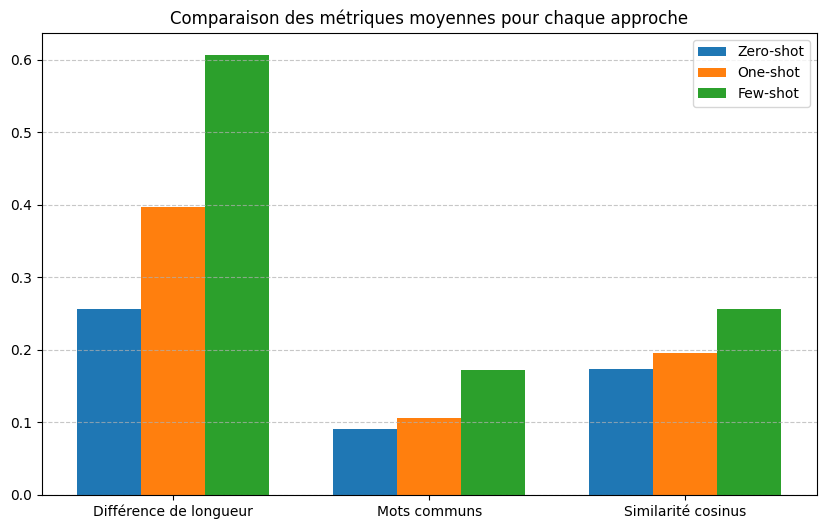

In [71]:
# Graphique des moyennes des métriques

import matplotlib.pyplot as plt
import numpy as np

values = [
    [avg_zero[m] for m in metrics],
    [avg_one[m] for m in metrics],
    [avg_few[m] for m in metrics]
]

values = np.array(values)

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, values[0], width, label='Zero-shot')
plt.bar(x, values[1], width, label='One-shot')
plt.bar(x + width, values[2], width, label='Few-shot')

plt.xticks(x, ['Différence de longueur', 'Mots communs', 'Similarité cosinus'])
plt.title('Comparaison des métriques moyennes pour chaque approche')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

TABLEAU COMPARATIF DES METRIQUES



| Métrique            | Zero-shot (moyenne) | One-shot (moyenne) | Few-shot (moyenne) |
|--------------------|-----------------|----------------|----------------|
| Différence de longueur  | 0.256           | 0.397          | 0.607          |
| Mots communs     | 0.091           | 0.106          | 0.172          |
| Similarité cosinus  | 0.174           | 0.196          | 0.256          |

INTERPRETATION DES RESULTATS

Le LLM renvoie presque toujours des réponses fausses, absurdes ou hors-sujet. Faire varier les paramètres d'inférences ne semble pas vraiment améliorer la qualité des réponses.

Les métriques indiquent que l'approche few-shots donne les meilleures résultats et l'approche one-shot de meilleures donne les moins bons résultats. Même si effectivement les réponses semblent être meilleures avec le few-shots, les résultats restent insuffisants et les trois métriques utilisées sont trop simples pour évaluer la qualité des réponses au niveau sémantique (par exemple détecter les hors-sujets ou les phrases absurdes).

## Pour aller plus loin : langchain

Faire le short course https://www.deeplearning.ai/short-courses/langchain-for-llm-application-development/

A partir des compétences fraîchement acquises, réaliser une chaîne de traitement qui
- Demande à l'utilisateur de charger un document PDF ou le charger depuis une URL
- Permet à l'utiisateur de poser des questions sur ce document
- Mémorise les conversations pour répondre aux questions

Votre application devra utiliser des templates de prompts.

- Suggestion de LLM à utiliser : https://huggingface.co/Qwen/Qwen2.5-3B-Instruct.